In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
dat = Table.read('spot-analysis/bkg-corrected-spots.csv')

In [3]:
# we're going to need to cut down the traces to where the actual activity starts, such that we don't have an absurd
# number of zeros at the beginning of our traces.

# For now, let's cut at t = 330 to take a look at what's going on

In [4]:
len(dat.columns)

77

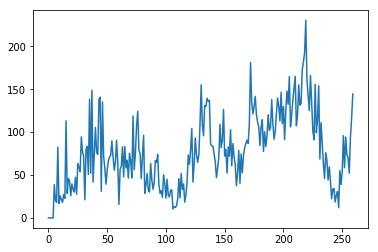

In [5]:
plt.plot(dat['Spot_50'][340:])

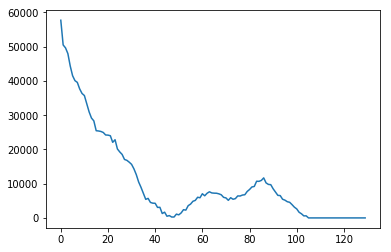

In [26]:
spot = dat['Spot_62'][340:]
corr = np.correlate(spot,spot, 'same')
plt.plot(corr[np.argmax(corr):])

In [6]:
trace_cutoff = 400   # define the hard cut that designates the "start time" for the average trace (get rid of starting zeros)

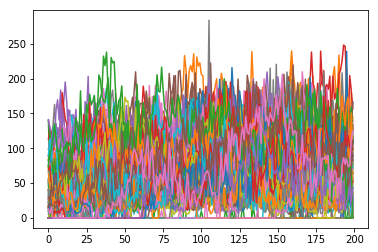

In [7]:
for name in dat.colnames:
    plt.plot(dat[name][trace_cutoff:])
plt.show()

In [8]:
# now let's compute the average autocorrelation for our dataset
n_traces = len(dat.columns)

auto_list = []

for name in dat.colnames:
    norm_trace = dat[name][trace_cutoff:] #/ np.max(dat[name])
    auto = np.correlate(norm_trace, norm_trace, 'same')
    
    #auto_list.append(auto / np.max(auto))
    auto_list.append(auto / np.std(norm_trace) * np.std(norm_trace))    # normalize autocorr fn by dividing by sigma^2

auto_list = np.asarray(auto_list)
    


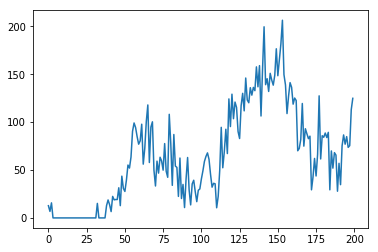

In [9]:
plt.plot(norm_trace)

In [10]:
len(auto_list)

77

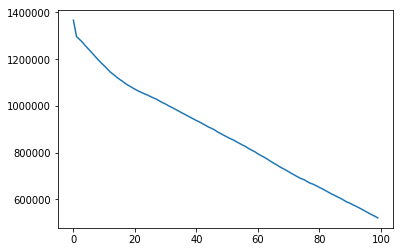

In [11]:
mean_auto = np.mean(auto_list, axis=0)

plt.plot(mean_auto[np.argmax(mean_auto):])

In [12]:
traces = []
for name in dat.colnames:
    traces.append(dat[name])

traces = np.asarray(traces)

In [13]:
# let's get an idea of the spread of our data by using the bootstrap method

# create a routine that bootstrap fits a set of data arrays

cutoff = np.argmax(mean_auto)         # take only the right half of autocorrelation fns, based on our og dataset's max
traces = np.asarray(traces)           # convert to a numpy array to play with indices
n_traces = len(traces)                # number of traces in our dataset
n_trials = 10000                      # how many times we wish to compute the bootstrap loop
trace_indx = np.arange(n_traces)      # the index range of the list of traces
auto_averages = []                    # list of averaged autocorrelation functions (should be n_trials long)


# sample randomly, with replacement, a new set of n_traces 10,000 times
for i in range(n_trials):
    
    # from our list of traces, sample radomly the trace_index of these datum in the list
    random_indx = np.random.choice(trace_indx, size=n_traces, replace=True)  
    
    # then use this array of indices to create our random distribution of traces
    sample_set = traces[random_indx]
    auto_list = []
    
    # next compute the autocorrelation function from this set of traces
    for sample in sample_set:
        aut = np.correlate(sample[trace_cutoff:], sample[trace_cutoff:], 'same')
        #auto_list.append(aut / np.max(aut))         # normalize each correlation for easy fitting later
        auto_list.append(aut)
        
    auto_mu = np.mean(auto_list, axis=0)            # now average together the autocorrelation functions from the list    
    auto_averages.append(auto_mu[cutoff:])          # add the right half of the average to the list of average autocorrelation functions



In [14]:
auto_averages = np.asarray(auto_averages)

In [15]:
# now let's compute the standard deviations of the set of 10000 autocorrelation functions. This is the STANDARD ERROR
# on our dataset
# compute at each time trace:
std_dev_arr = np.std(auto_averages, axis=0)

In [16]:
#plt.plot(std_dev_arr);

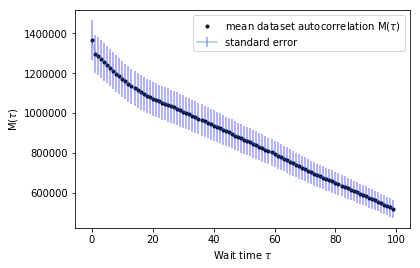

In [17]:
tau = np.arange(len(mean_auto[cutoff:]))   # tau array to plot against

plt.errorbar(x=tau, y=mean_auto[cutoff:], yerr=(std_dev_arr, std_dev_arr), ecolor='b', alpha=0.4, label = 'standard error')  

# show the mean of our original dataset in red
plt.scatter(tau, mean_auto[cutoff:], marker='.', color='k', label = r'mean dataset autocorrelation M($\tau$)')
plt.legend()
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'M($\tau$)')
plt.show()

In [18]:
def decay_model(x, a):
    return np.exp(-x*a)

In [19]:
from scipy.optimize import curve_fit

popt,pcov = curve_fit(decay_model, tau, mean_auto[cutoff:] / np.max(mean_auto[cutoff:]))

In [20]:
popt

array([0.00949335])

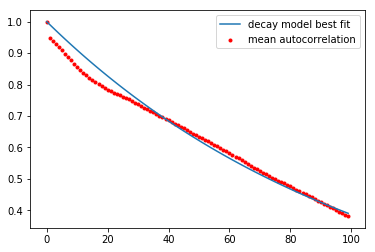

In [21]:
#plt.plot(tau, mean_auto_data[cutoff:])
plt.plot(tau, decay_model(tau, popt[0]), label='decay model best fit')
plt.scatter(tau, mean_auto[cutoff:] / np.max(mean_auto[cutoff:]), color='r', marker='.', label = 'mean autocorrelation')   # show the mean of our original dataset in red
plt.legend()
plt.show()